### Patryk Gawłowski 263646, Jakub Wolski 263619

# Prezentacja programu znajdującego anomalię w obrazie z tłem
# 1. Wygenerowanie tła z kwadracikami

In [69]:
# DEPENDENCIES
import numpy as np
from matplotlib import pyplot as plt
import cv2
from PIL import Image

In [70]:
def generate_random_image(val_min, val_max, img_size):
    return np.random.randint(val_min, val_max, img_size, dtype=np.uint8)


In [71]:
def generate_random_squares(image, amount, maxSize):
    x_max, y_max = image.shape[:2]
    listOfAnomalies=[]
    
    for _ in range(amount):
        # Generate random coordinates for the square
        squareLength=np.random.randint(10,maxSize+1)
        squareHeight=np.random.randint(10,maxSize+1)
        
        y_start = np.random.randint(0, x_max - squareHeight)
        x_start = np.random.randint(0, y_max - squareLength)
        
        # Generate random color for the square (R, G, B)
        color = np.random.randint(0, 256, size=3)
        anomaly=(x_start, y_start, color[0], color[1], color[2], squareLength, squareHeight)
        listOfAnomalies.append(anomaly)
        # Assign the color to the corresponding region in the image
        image[y_start:y_start+squareHeight, x_start:x_start+squareLength, :] = color
    
    return image, listOfAnomalies

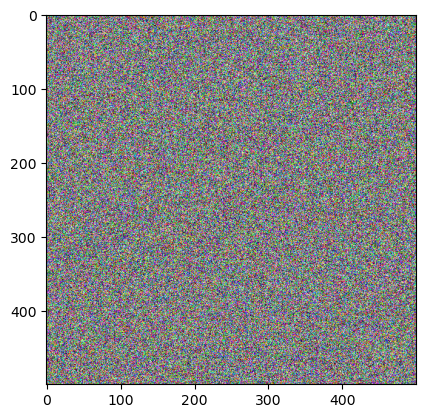

In [72]:
random_bckgrnd = generate_random_image(val_min=0, val_max=255, img_size=(500, 500, 3))
plt.imshow(random_bckgrnd, cmap='gray')




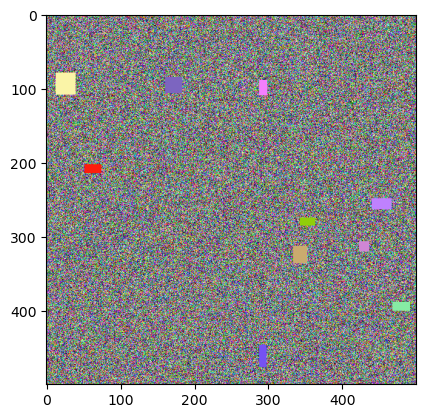

In [73]:
random_image, listOfAnomalies = generate_random_squares(image=random_bckgrnd, amount=10,maxSize= 30)
plt.imshow(random_image)

# 2. Pocięcie obrazu na równe kawałki i wybranie tych, w których są anomalie na podstawie histogramu

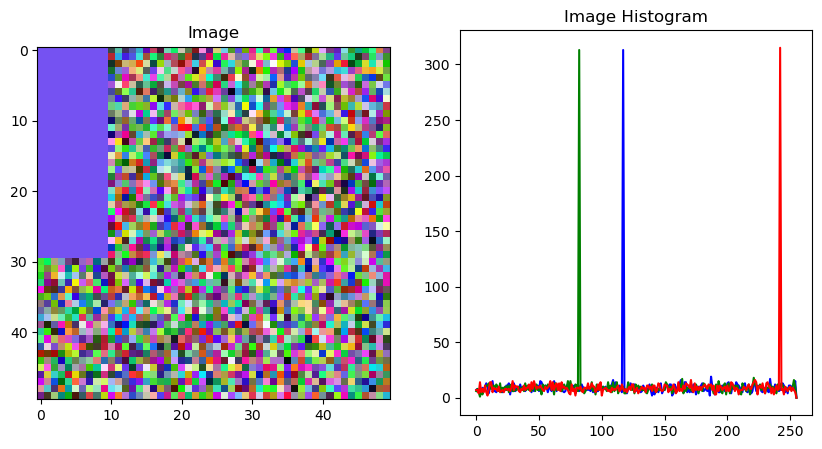

In [74]:
random_image_Image=Image.fromarray(random_image.copy())

im_crop = random_image_Image.crop((listOfAnomalies[0][0], listOfAnomalies[0][1],listOfAnomalies[0][0]+50, listOfAnomalies[0][1]+50))

im_crop = np.asarray(im_crop)

bHist = cv2.calcHist([im_crop], [0], None, [256], [0, 256]) 
gHist = cv2.calcHist([im_crop], [1], None, [256], [0, 256]) 
rHist = cv2.calcHist([im_crop], [2], None, [256], [0, 256]) 

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title('Image') 
plt.imshow(im_crop)

plt.subplot(1,2,2)
plt.plot(bHist, color='b') 
plt.plot(gHist, color='g') 
plt.plot(rHist, color='r') 
plt.title('Image Histogram') 
plt.show()


In [75]:
def hasAnomaly(img, threshold):
    img=np.asarray(img)
    bHist = cv2.calcHist([img], [0], None, [256], [0, 256]) 
    gHist = cv2.calcHist([img], [1], None, [256], [0, 256]) 
    rHist = cv2.calcHist([img], [2], None, [256], [0, 256]) 

    bMax=np.max(bHist)
    gMax=np.max(gHist)
    rMax=np.max(rHist)

    bMean=np.mean(bHist)
    gMean=np.mean(gHist)
    rMean=np.mean(rHist)

    if bMax>threshold*bMean or rMax>threshold*rMean or gMax>threshold*gMean:
        return True
    return False

In [76]:

listOfSquaresCoordinates=[]

for y in range(0, 500, 50):
    for x in range(0, 500, 50):
        croppedImg = random_image_Image.crop((x, y, x+50, y+50))
        if hasAnomaly(croppedImg, 2.5
                     ):
            anomaliesCoordinates=(x,y)
            listOfSquaresCoordinates.append(anomaliesCoordinates)

# 3. Wyświetlenie wyciętych kawałków z anomaliami

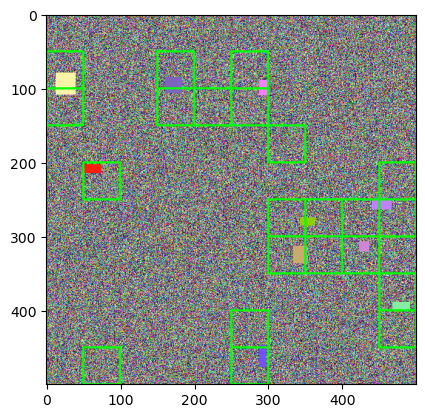

In [77]:
foundSquaresImg=random_image.copy()

for x,y in listOfSquaresCoordinates:
    cv2.rectangle(foundSquaresImg, (x, y), (x + 50, y + 50), (0, 255, 0), 2)  # Draw green rectangles

plt.figure()
plt.imshow(foundSquaresImg)


# 4. Dokładniejsze przeszukanie wycinków

In [78]:
def findColor(img):

    img=np.asarray(img)
    
    blue_color = cv2.calcHist([img], [0], None, [256], [0, 256]) 
    green_color = cv2.calcHist([img], [1], None, [256], [0, 256]) 
    red_color = cv2.calcHist([img], [2], None, [256], [0, 256]) 

    R=np.argmax(blue_color)
    G=np.argmax(green_color)
    B=np.argmax(red_color)
    return (R,G,B)

In [79]:

listOfCoordinatesSmall=[]


for xBigSquare, yBigSquare in listOfSquaresCoordinates:
    for y in range(0, 50, 10):
        for x in range(0, 50, 10):
            BigSquare=random_image_Image.crop((xBigSquare,yBigSquare, xBigSquare+50 ,yBigSquare+50))
            croppedImg = BigSquare.crop((x, y, x+10, y+10))
            if hasAnomaly(croppedImg, 15):
                R, G, B = findColor(croppedImg)
                anomaliesCoordinates=(xBigSquare+x,yBigSquare+y,R,G,B)
                listOfCoordinatesSmall.append(anomaliesCoordinates)

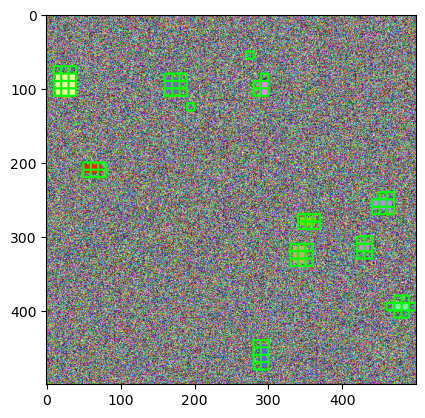

In [80]:
foundSmallSquaresImg=random_image.copy()

for x,y, _, _, _ in listOfCoordinatesSmall:
    cv2.rectangle(foundSmallSquaresImg, (x, y), (x + 10, y + 10), (0, 255, 0), 2)  # Draw green rectangles

plt.figure()
plt.imshow(foundSmallSquaresImg)

# 5. Stworzenie etykiet i predykcji

In [81]:
def isInside(squareX, squareY, x, y, szer_obszar, wys_obszar):
    if ((squareX > x and squareX < x+szer_obszar and squareY > y and squareY < y+wys_obszar) or
       (squareX+10 > x and squareX+10 < x+szer_obszar and squareY > y and squareY < y+wys_obszar) or
       (squareX > x and squareX < x+szer_obszar and squareY+10 > y and squareY+10 < y+wys_obszar) or
       (squareX+10 > x and squareX+10 < x+szer_obszar and squareY+10 > y and squareY+10 < y+wys_obszar) or 
       (squareX==x and squareY+10 > y and squareY+10 < y+wys_obszar) or
       (squareX==x and squareY > y and squareY < y+wys_obszar) or 
       (squareY==y and squareX+10 > x and squareX+10 < x+szer_obszar) or
       (squareY==y and squareX > x and squareX < x+szer_obszar) or
       (squareX==x and squareY==y)):
        return True
    else:
        return False

In [82]:
labels=[]
anomaliesCoordiates=[]

for y in range(0, 500, 10):
    for x in range(0, 500, 10):
        isAnomaly=False
        for kwadrat in listOfAnomalies:
            if isInside(x, y, kwadrat[0], kwadrat[1], kwadrat[5], kwadrat[6]):
                isAnomaly=True
                cords=(x,y, kwadrat[2],kwadrat[3], kwadrat[4])
                anomaliesCoordiates.append(cords)
                break
        if isAnomaly:
            labels.append(1)
        else:
            labels.append(0)
         

[(288, 447, 117, 82, 242, 10, 30), (334, 313, 202, 171, 110, 19, 24), (52, 203, 254, 28, 13, 23, 12), (423, 307, 208, 134, 213, 14, 14), (288, 89, 245, 127, 254, 11, 21), (440, 249, 191, 129, 254, 27, 15), (343, 275, 145, 206, 9, 21, 11), (13, 79, 250, 244, 167, 27, 30), (468, 389, 134, 235, 164, 24, 12), (161, 85, 124, 101, 192, 23, 22)]


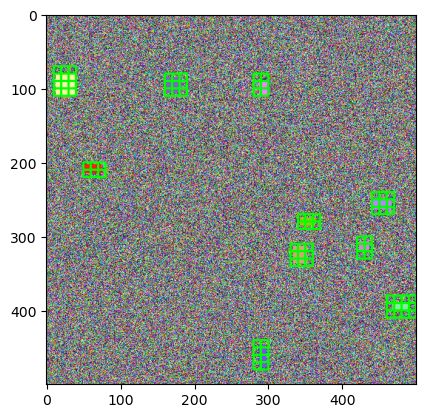

In [85]:
imgLabels=random_image.copy()

for x, y, _, _, _ in anomaliesCoordiates:
    cv2.rectangle(imgLabels, (x, y), (x + 10, y + 10), (0, 255, 0), 2)  # Draw green rectangles

plt.figure()
plt.imshow(imgLabels)

print(listOfAnomalies)

In [86]:
result=[]

for y in range(0, 500, 10):
    for x in range(0, 500, 10):
        hasAnomaly=False
        for squareX , squareY,_, _, _ in listOfCoordinatesSmall:
            if x==squareX and y==squareY:
                hasAnomaly=True
        if hasAnomaly:
            result.append(1)
        else:
            result.append(0)

# 6. Przedstawienie jakości

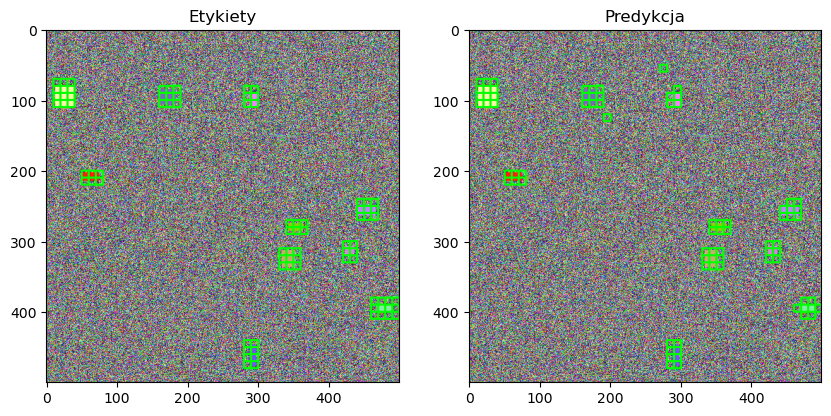

In [87]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Etykiety")
plt.imshow(imgLabels)

plt.subplot(1, 2, 2)
plt.title("Predykcja")
plt.imshow(foundSmallSquaresImg)

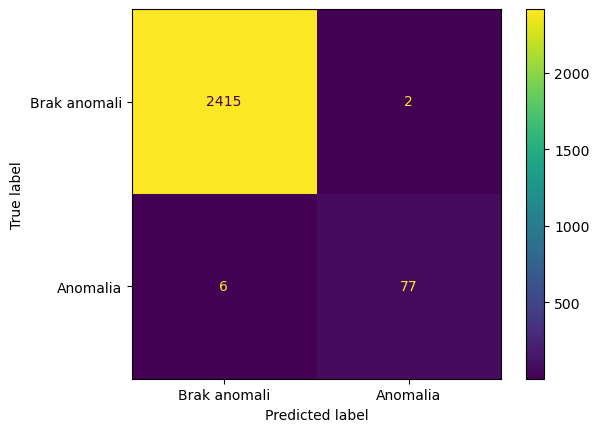

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

names=("Brak anomali", "Anomalia")

cm = confusion_matrix(labels, result, labels=(0,1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
sns.reset_orig()
disp.plot()
plt.show()

In [89]:
from sklearn.metrics import f1_score
from sklearn import metrics

# Obliczanie F1 score
accuracy=metrics.accuracy_score(labels, result)
f1 = f1_score(labels, result)

print("Accuracy:", accuracy)
print("F1 score:", f1)


Accuracy: 0.9968
F1 score: 0.9506172839506173


# 7. Kolor anomalii

In [90]:
goodColoSum=0
wrongColoSum=0


for element1 in anomaliesCoordiates:
    for element2 in listOfCoordinatesSmall:
        if element1[:2] == element2[:2]:
            print(f"Orginalny kolor: {element1[2:]}" + f" Znaleziony kolor: {element2[2:]} \n")
            if element1[2:]==element2[2:]:
                goodColoSum+=1
            else:
                wrongColoSum+=1
           



Orginalny kolor: (250, 244, 167) Znaleziony kolor: (250, 244, 167) 

Orginalny kolor: (250, 244, 167) Znaleziony kolor: (250, 244, 167) 

Orginalny kolor: (250, 244, 167) Znaleziony kolor: (250, 244, 167) 

Orginalny kolor: (250, 244, 167) Znaleziony kolor: (250, 244, 167) 

Orginalny kolor: (250, 244, 167) Znaleziony kolor: (250, 244, 167) 

Orginalny kolor: (250, 244, 167) Znaleziony kolor: (250, 244, 167) 

Orginalny kolor: (124, 101, 192) Znaleziony kolor: (124, 101, 192) 

Orginalny kolor: (124, 101, 192) Znaleziony kolor: (124, 101, 192) 

Orginalny kolor: (124, 101, 192) Znaleziony kolor: (124, 101, 192) 

Orginalny kolor: (245, 127, 254) Znaleziony kolor: (245, 127, 254) 

Orginalny kolor: (250, 244, 167) Znaleziony kolor: (250, 244, 167) 

Orginalny kolor: (250, 244, 167) Znaleziony kolor: (250, 244, 167) 

Orginalny kolor: (250, 244, 167) Znaleziony kolor: (250, 244, 167) 

Orginalny kolor: (124, 101, 192) Znaleziony kolor: (124, 101, 192) 

Orginalny kolor: (124, 101, 192) Z

In [91]:
print(f"Ilość dobrze znalezionych kolorów: {goodColoSum}")
print(f"Ilość źle znalezionych kolorów: {wrongColoSum}")

Ilość dobrze znalezionych kolorów: 77
Ilość źle znalezionych kolorów: 0
